# supernodes

The procedure of combining public transportation stops into supernodes.

Requires:
1. `data/preprocessed/stops.json`
2. `data/preprocessed/routes.json`

Produces:
1. `data/supernodes/supernode_threshold_metrics.json`
2. `data/supernodes/supernodes.json`

Alters:
1. `data/preprocessed/stops.json` (adds stop to supernode mapping)
2. `data/preprocessed/routes.json` (adds stops to supernodes mapping)

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import Set, Tuple, List

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from cartopy import crs as ccrs
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle

from myutils.spatial import get_earth_distances
from myutils.json import save_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from config import stops_fpath, routes_fpath, supernode_threshold_metrics_fpath, \
    supernodes_fpath
from cartopy_config import vaska_area, get_node_props, supernode_color, supernode_zorder
from ptn.cartopy import add_map_subplot

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
stops = pd.read_json(stops_fpath, encoding='utf-8').set_index('id')

stops.head(2)

,type,name,lat,lon,diameter,supernode
id,,,,,,
16396,tram,"Конечная станция ""Река Оккервиль""",59.908881,30.494671,0.0,620
16367,tram,Пр. Солидарности,59.911857,30.499882,0.0,827


In [4]:
coords = stops[['lat', 'lon']]

coords.head(2)

,lat,lon
id,,
16396,59.908881,30.494671
16367,59.911857,30.499882


In [5]:
diameters = stops['diameter'].values
shifts = (diameters.reshape(-1, 1) + diameters.reshape(1, -1)) / 2

distances = get_earth_distances(coords.values, coords.values) - shifts

distances.shape

(7661, 7661)

In [12]:
def build_supernodes(th: float) -> pd.DataFrame:
    closeness_adj_mx = (distances <= th).astype(int)
    closeness_graph = nx.from_numpy_array(closeness_adj_mx)

    id2stop_id = dict(enumerate(stops.index))
    
    closeness_graph = nx.relabel_nodes(closeness_graph, id2stop_id)

    supernodes = sorted(nx.connected_components(closeness_graph), key=len, reverse=True)
    
    def supernode_diameter(supernode: Set[int]) -> float:
        coords_ = coords.loc[supernode, ['lat', 'lon']].values
        distances_ = get_earth_distances(coords_, coords_)
        diameter = distances_.max()

        return diameter

    supernode_diameters = [supernode_diameter(supernode) for supernode in supernodes]
    
    supernodes_df = []

    for i, supernode in enumerate(supernodes):
        lat, lon = coords.loc[supernode, ['lat', 'lon']].mean()
        diameter = supernode_diameter(supernode)
        types = stops.loc[stops.index.isin(supernode), 'type'].unique().tolist()

        supernodes_df.append({
            'id': i,
            'stops': list(supernode),
            'diameter': diameter,
            'types': types,
            'lat': lat,
            'lon': lon,
        })
        
    return pd.DataFrame(supernodes_df)

In [6]:
metrics = pd.read_json(supernode_threshold_metrics_fpath, encoding='utf-8').set_index('th')

metrics.head(2)

,size_mean,size_w1,size_w2,size_t1,size_t2,size_max,diameter_mean,diameter_w1,diameter_w2,diameter_t1,diameter_t2,diameter_max
th,,,,,,,,,,,,
0.000,1.005909,1.0,1.0,1.002626,1.009979,10,0.000217,0.0,0.0,0.000075,0.000384,0.330471
0.025,1.231474,1.0,1.0,1.218132,1.245137,11,0.003270,0.0,0.0,0.002967,0.003636,0.699989


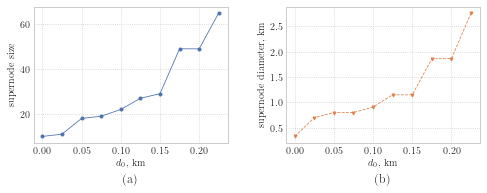

In [10]:
fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(8, 2.5)
fig.subplots_adjust(wspace=0.3)

markers = ['o', 'v']
linestyles = ['solid', 'dashed']

for i, metric, ax in zip(range(2), ['size', 'diameter'], axes):
    color = f'C{i}'
    marker = markers[i]
    linestyle = linestyles[i]
    
    # ax.plot(metrics[f'{metric}_mean'], c=color, lw=0.8, marker='.', markersize=3)
#     ax.fill_between(
#         metrics.index,
#         metrics[f'{metric}_t1'],
#         metrics[f'{metric}_t2'],
#         color=color,
#         alpha=0.15,
#     )
    
    ax.plot(metrics[f'{metric}_max'], c=color, lw=0.8, ls=linestyle, marker=marker, markersize=3)
    
    # ax.set_title(metric)
    ax.set_xlabel('$d_0$, km')
    
axes[0].set_ylabel('supernode size')
axes[0].set_title('(a)', y=-0.34)
axes[1].set_ylabel('supernode diameter, km')
axes[1].set_title('(b)', y=-0.34)

plt.savefig('../figures/supernode_threshold_metrics.pdf', transparent=True, bbox_inches='tight')

In [13]:
supernodes = build_supernodes(0.1)

supernodes.head(2)

,id,stops,diameter,types,lat,lon
0,0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


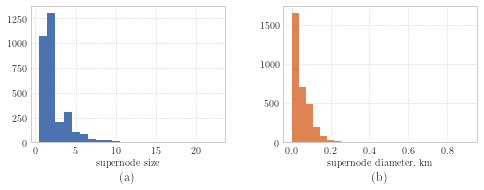

In [14]:
supernode_sizes = supernodes['stops'].apply(len).value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(8, 2.5)
fig.subplots_adjust(wspace=0.3)

ax1.bar(supernode_sizes.index, supernode_sizes.values, width=1)
ax1.set_xlabel('supernode size')
ax1.set_title('(a)', y=-0.32)

ax2.hist(supernodes['diameter'], color='C1', bins=25)
ax2.set_xlabel('supernode diameter, km')
ax2.set_title('(b)', y=-0.32)

plt.savefig('../figures/supernode_statistics.pdf', transparent=True, bbox_inches='tight')

In [15]:
supernodes_json = [row.to_dict() for _, row in supernodes.iterrows()]

len(supernodes_json)

3202

In [16]:
supernodes_json[0]

{'id': 0,
 'stops': [29058,
  15366,
  1687,
  1688,
  15385,
  2080,
  2081,
  52,
  1337,
  24382,
  3268,
  2887,
  4046,
  29008,
  16603,
  31331,
  31332,
  31333,
  14692,
  16484,
  2549,
  25727],
 'diameter': 0.7329634436206482,
 'types': ['bus', 'trolley', 'tram', 'subway'],
 'lat': 59.851709954156895,
 'lon': 30.322415197727267}

In [17]:
save_json(supernodes_json, supernodes_fpath)

In [18]:
stop2supernode = {
    stop: supernode['id']
    for i, supernode in supernodes.iterrows()
    for stop in supernode['stops']
}

stops['supernode'] = stops.index.map(stop2supernode)

stops.head(2)

,type,name,lat,lon,diameter,supernode
id,,,,,,
16396,tram,"Конечная станция ""Река Оккервиль""",59.908881,30.494671,0.0,620
16367,tram,Пр. Солидарности,59.911857,30.499882,0.0,827


In [19]:
stops_json = [row.to_dict() for _, row in stops.reset_index().iterrows()]

stops_json[0]

{'id': 16396,
 'type': 'tram',
 'name': 'Конечная станция "Река Оккервиль" ',
 'lat': 59.9088808952478,
 'lon': 30.4946709,
 'diameter': 0.0,
 'supernode': 620}

In [16]:
save_json(stops_json, stops_fpath)

In [20]:
routes = pd.read_json(routes_fpath, encoding='utf-8')

routes.head(2)

,name,type,direction,stops,id,distance,supernodes
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",11125,3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [21]:
def get_supernode_route(route: List[int]) -> List[int]:
    supernode_route = []
    
    for stop in route:
        supernode = stop2supernode[stop]
        
        if len(supernode_route) > 0 and supernode_route[-1] == supernode:
            continue
            
        supernode_route.append(supernode)
        
    return supernode_route


routes['supernodes'] = routes['stops'].apply(get_supernode_route)

routes.head(2)

,name,type,direction,stops,id,distance,supernodes
0,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",1125,5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
1,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",11125,3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [22]:
routes_json = [row.to_dict() for _, row in routes.iterrows()]

routes_json[0]

{'name': 'А',
 'type': 'tram',
 'direction': 1,
 'stops': [16396,
  16367,
  16371,
  16398,
  16400,
  16401,
  16405,
  16408,
  16410,
  16413,
  30720,
  27185,
  16415,
  33093],
 'id': 1125,
 'distance': 5.008429911444193,
 'supernodes': [620, 827, 828, 20, 309, 80, 310, 204, 5, 29, 118, 119, 30]}

In [20]:
save_json(routes_json, routes_fpath)

***

In [23]:
def get_supernode_radius(supernode: pd.Series) -> float:
    radius = get_earth_distances(
        stops.loc[supernode['stops'], ['lat', 'lon']].values,
        supernode[['lat', 'lon']].values.astype(float).reshape(1, -1),
    ).max()
    
    return radius


supernode_radii = pd.Series({
    i: get_supernode_radius(supernode)
    for i, supernode in supernodes.iterrows()
})

supernodes['radius'] = supernode_radii

supernodes.head(2)

,id,stops,diameter,types,lat,lon,radius
0,0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415,0.370776
1,1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937,0.472779


In [24]:
stop_coords = stops[['lon', 'lat']]

stop_coords.head(2)

,lon,lat
id,,
16396,30.494671,59.908881
16367,30.499882,59.911857


In [25]:
import warnings

warnings.filterwarnings('ignore')

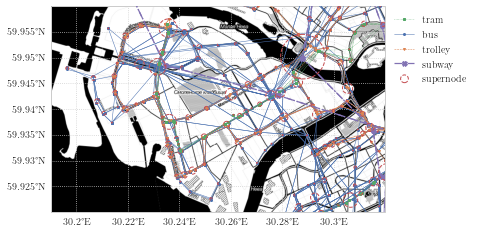

In [26]:
fig = plt.figure(figsize=(6, 5))

extent, scale, factor = vaska_area

ax = add_map_subplot(fig, 1, 1, 1, extent=extent, scale=scale)

for t in routes['type'].unique():
    type_routes = routes[routes['type'] == t].copy()
    
    color, marker, size, width, linestyle, zorder = get_node_props(t, factor)
    
    for i, route in enumerate(type_routes['stops']):
        x, y = stop_coords.loc[route].values.T
        
        label = t if i == 0 else None
        
        ax.plot(x, y, transform=ccrs.PlateCarree(), marker=marker, markersize=size,
                lw=width, ls=linestyle, c=color, label=label, zorder=zorder)
        
for i, supernode in supernodes.iterrows():
    x, y = supernode[['lon', 'lat']]
    # x, y = proj.transform_point(x, y, ax.projection)
    
    radius = supernode['radius'] + 0.01
    
    if x + radius < extent[0] or x - radius > extent[1] or y + radius < extent[2] or y - radius > extent[3]:
        continue
        
    ax.tissot(radius, lons=x, lats=y, zorder=supernode_zorder, edgecolor=supernode_color, linewidth=1, linestyle='dashed', facecolor='None')

handles, labels = ax.get_legend_handles_labels()

handles.append(plt.scatter([0], [0], marker='o', s=60, facecolor='None', color=supernode_color, linewidth=1, linestyle='dashed'))
labels.append('supernode')
    
ax.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('../figures/supernodes_map.png', dpi=250, transparent=True, bbox_inches='tight')